# Ligand receptor specfic enrichment analysis

In [1]:
import os
import spateo as st
import dynamo as dyn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

2023-10-12 13:26:44.219187: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 13:26:44.263711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:26:44.877933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cur

In [2]:
import anndata

In [3]:
import os

os.chdir('/home/mowp/workspace/single_cell_analysis/spateo')

In [4]:
adata = anndata.read_h5ad('axolotl_2DPI.h5ad')
adata

AnnData object with n_obs × n_vars = 7668 × 27324
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'inj_M_L', 'Annotation'
    var: 'Axolotl_ID', 'hs_gene'
    uns: 'Annotation_colors', '__type', 'color_key'
    obsm: 'X_spatial', 'spatial'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [5]:
adata.var['new_name'] = adata.var.index
adata.var.index = adata.var['Axolotl_ID']

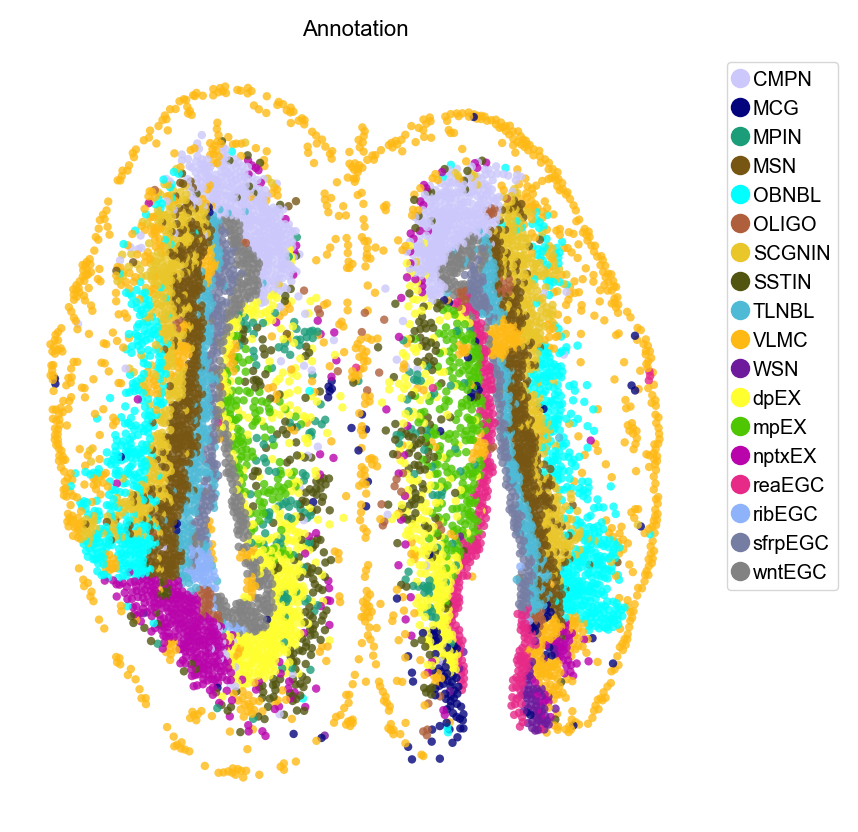

In [6]:
st.pl.space(adata,
            color=['Annotation'],
            pointsize=0.2,
            color_key=adata.uns['color_key'],
            show_legend='upper left',
            figsize=(5, 5))

## Construct new adata.

First, calculate spatial nearest neighbor graph, limiting the nearest neighbor per cell to k. This function returns another anndata object, in which the columns of the matrix are cell-cell pairs, while the rows ligand-receptor mechanisms.

首先，计算空间最近邻图，将每个单元的最近邻限制为 k 。此函数返回另一个anndata对象，其中矩阵的列是细胞-细胞对，而行是配体-受体机制。

In [7]:
weights_graph, distance_graph, adata = st.tl.weighted_spatial_graph(
    adata,
    n_neighbors=10,
)

|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_weights to obsp in AnnData Object.


In [8]:
adata_n2n = st.tl.niches(adata,
                         path='/home/mowp/software/spateo-release/spateo/tools/database/',
                         layer=None,
                         species='axolotl',
                         system='niches_n2n',
                         method='sum')
adata_n2n

/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name'

In [9]:
adata_n2n.uns['__type'] = 'UMI'
adata_n2n.obsm['spatial'] = adata.obsm['spatial']

## Downstream analysis

Then, we can do dimensionality reduction , spatial clustering and differential mechanisms (ligand-receptor) analysis based on this new object. Therefore, we can find the ligand-receptor pairs which are specially enriched in a certain region.

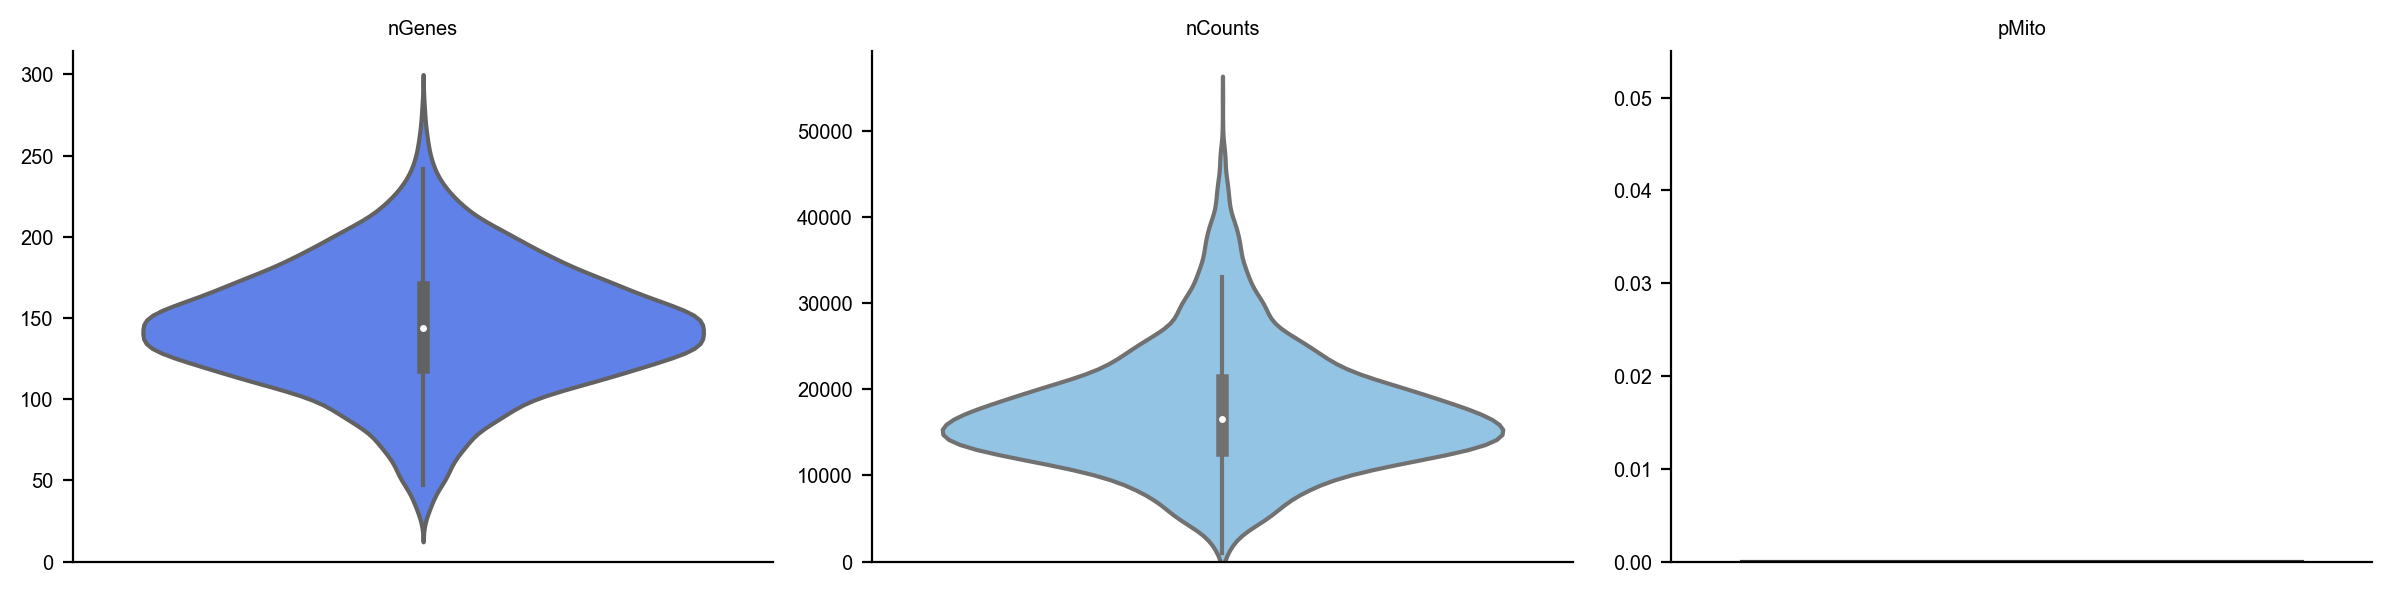

|-----> Set <adata.X> to normalized data


/tmp/ipykernel_2029632/3625349864.py:6: DeprecationWarning:

normalize_cell_expr_by_size_factors is deprecated and will be removed in a future release. Please update your code to use the new replacement function.



AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'Size_Factor', 'initial_cell_size'
    var: 'nCells', 'nCounts'
    uns: '__type', 'pp'
    obsm: 'spatial', 'pearson_residuals'
    layers: 'raw', 'norm_log1p'

In [10]:
adata_n2n.obs['n_counts'] = adata_n2n.X.sum(axis=1).A1
adata_n2n.uns["pp"] = {}
adata_n2n.var_names_make_unique()
dyn.pl.basic_stats(adata_n2n)
adata_n2n.layers['raw'] = adata_n2n.X
dyn.pp.normalize_cell_expr_by_size_factors(adata_n2n, layers="X")
adata_n2n.layers['norm_log1p'] = adata_n2n.X.copy()
adata_n2n.X = adata_n2n.layers['raw'].copy()
st.tl.pearson_residuals(adata_n2n, n_top_genes=None)
adata_n2n

In [11]:
bad_genes = np.isnan(adata_n2n.obsm["pearson_residuals"].sum(0))
bad_genes.sum()
st.tl.pca_spateo(adata=adata_n2n, X_data=adata_n2n.obsm["pearson_residuals"]
                 [:, ~bad_genes], n_pca_components=30, pca_key="X_pca", random_state=1)
dyn.tl.neighbors(adata_n2n, n_neighbors=30)

|-----> Runing PCA on user provided data...


|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'Size_Factor', 'initial_cell_size'
    var: 'nCells', 'nCounts'
    uns: '__type', 'pp', 'neighbors'
    obsm: 'spatial', 'pearson_residuals', 'X_pca'
    layers: 'raw', 'norm_log1p'
    obsp: 'distances', 'connectivities'

In [12]:
adata_n2n_bak = adata_n2n.copy()

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [52.4362s]


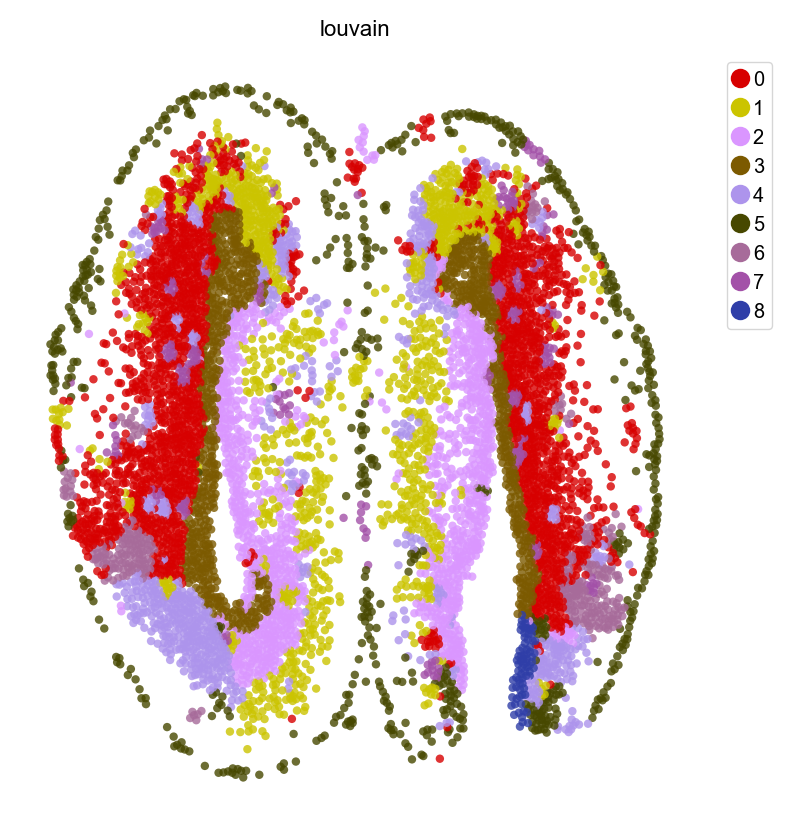

In [13]:
adata_n2n = adata_n2n_bak.copy()
dyn.tl.louvain(adata_n2n, resolution=0.5)
st.pl.space(adata_n2n,
            color=['louvain'],
            pointsize=0.2,
            figsize=(5, 5),
            show_legend="upper left")


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [42.2604s]


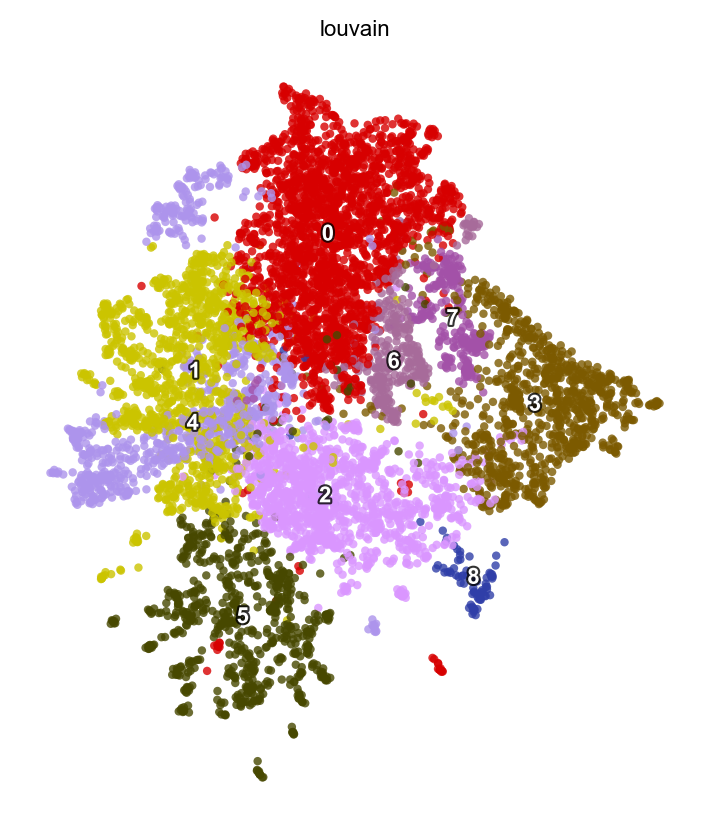

In [14]:
dyn.tl.reduceDimension(adata_n2n)
st.pl.space(adata_n2n,
            color=['louvain'],
            figsize=(5, 5),
            space="umap",
            pointsize=0.2)

In [15]:
adata_n2n.var['lr_pair_name'] = adata_n2n.var.index

## differential analysis

In [16]:
# (optional: just Suitable for axolotl, homologous gene to human)
#adata_n2n.var['lr_pair_name'] = adata_n2n.var.index
df = adata_n2n.var['lr_pair_name'].str.split('-', expand=True)
df.columns = ['ligand', 'receptor']
##
df1 = adata.var
df1.index.name = None
df2 = pd.merge(df, df1, left_on='ligand', right_on='Axolotl_ID').drop(
    ['Axolotl_ID', 'new_name'], axis=1)
df2.columns = ['ligand', 'receptor', 'ligand_human']
df3 = pd.merge(df2, df1, left_on='receptor',
               right_on='Axolotl_ID').drop(['Axolotl_ID', 'new_name'], axis=1)
df3.columns = ['ligand', 'receptor', 'ligand_human', 'receptor_human']
df3['ligand_human'] = df3['ligand_human'].astype('str')
df3['receptor_human'] = df3['receptor_human'].astype('str')
df3['lr_pair'] = df3["ligand_human"] + "-" + df3["receptor_human"]
adata_n2n.var['lr_pair'] = df3['lr_pair'].tolist()
adata_n2n.var.index = adata_n2n.var['lr_pair']

In [17]:
adata_n2n.var

,nCells,nCounts,lr_pair_name,lr_pair
lr_pair,,,,
SEMA3F-NRP2,2105,53770.0,AMEX60DDU001005418-AMEX60DD055040,SEMA3F-NRP2
SEMA3G-NRP2,1052,10685.0,AMEX60DD030506-AMEX60DD053102,SEMA3G-NRP2
SEMA3C-NRP2,147,1699.0,AMEX60DD007589-AMEX60DD022047,SEMA3C-NRP2
SEMA3A-NRP2,1328,70932.0,AMEX60DD007589-AMEX60DD055396,SEMA3A-NRP2
VEGFD-NRP2,10,38.0,AMEX60DD006587-AMEX60DD027855,VEGFD-NRP2
...,...,...,...,...
F2-F2RL2,58,669.0,AMEX60DD039450-AMEX60DD011301,F2-F2RL2
NUCB2-ERAP1,1145,7467.0,AMEX60DD052441-AMEX60DD030011,NUCB2-ERAP1
FAT4-DCHS1,215,2903.0,AMEX60DD039450-AMEX60DDU001005617,FAT4-DCHS1


In [18]:
adata_n2n.obs

,cell_pair_name,n_counts,nGenes,nCounts,pMito,Size_Factor,initial_cell_size,louvain
0,"Index(['CELL.8-CELL.8', 'CELL.8-CELL.12', 'CEL...",3715.0,94,3715.0,0,0.225158,3715.0,5
1,"Index(['CELL.9-CELL.9', 'CELL.9-CELL.8', 'CELL...",4153.0,91,4153.0,0,0.251705,4153.0,5
2,"Index(['CELL.10-CELL.10', 'CELL.10-CELL.31', '...",8882.0,92,8882.0,0,0.538319,8882.0,5
3,"Index(['CELL.11-CELL.11', 'CELL.11-CELL.22', '...",4413.0,56,4413.0,0,0.267463,4413.0,5
4,"Index(['CELL.12-CELL.12', 'CELL.12-CELL.8', 'C...",3674.0,94,3674.0,0,0.222673,3674.0,5
...,...,...,...,...,...,...,...,...
7663,"Index(['CELL.8411-CELL.8411', 'CELL.8411-CELL....",4583.0,67,4583.0,0,0.277766,4583.0,5
7664,"Index(['CELL.8412-CELL.8412', 'CELL.8412-CELL....",8258.0,45,8258.0,0,0.500500,8258.0,5
7665,"Index(['CELL.8413-CELL.8413', 'CELL.8413-CELL....",10481.0,60,10481.0,0,0.635231,10481.0,5
7666,"Index(['CELL.8414-CELL.8414', 'CELL.8414-CELL....",11618.0,58,11618.0,0,0.704143,11618.0,5


In [19]:
adata_n2c_marker = st.tl.find_all_cluster_degs(
    adata_n2n, group='louvain', genes=None, n_jobs=10)


# fix bug for tools/cluster_degs.py Line 211
# all_vals = all_vals.reshape(-1)

2023-10-12 13:28:38.560032: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 13:28:38.628424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 13:28:38.729018: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 13:28:38.812520: I tensorflow/core/platform/cpu_feature_guard.cc:182]

In [20]:
adata_n2c_marker

AnnData object with n_obs × n_vars = 7668 × 916
    obs: 'cell_pair_name', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'Size_Factor', 'initial_cell_size', 'louvain'
    var: 'nCells', 'nCounts', 'lr_pair_name', 'lr_pair'
    uns: '__type', 'pp', 'neighbors', 'louvain', 'louvain_colors', 'umap_fit', 'cluster_markers'
    obsm: 'spatial', 'pearson_residuals', 'X_pca', 'X_spatial', 'X_umap'
    layers: 'raw', 'norm_log1p'
    obsp: 'distances', 'connectivities'

In [21]:
# top_n_markers
marker_genes_dict = st.tl.top_n_degs(
    adata_n2c_marker, group='louvain', top_n_genes=3)

# pandas version must be <= 2.0, otherwise will raise error 
# Error "'DataFrame' object has no attribute 'append'"

In [23]:
marker_genes_dict 

{'0': ['WNT7B-FZD10', 'MMP9-RECK', 'APP-TSPAN15'],
 '1': ['CDH1-ERBB3', 'FN1-ITGB3', 'GNAI2-ADCY7'],
 '2': ['WNT2B-FZD4', 'FGF2-SDC2', 'NLGN3-NRXN2'],
 '3': ['CCN2-EGFR', 'LAMA2-ITGA2', 'COL1A2-ITGB3'],
 '4': ['LAMC1-ITGA6', 'TGFB1-ITGAV', 'VEGFD-ITGA5'],
 '5': ['TPH1-HTR1A', 'COL1A2-ITGA2', 'MMP2-FGFR1'],
 '6': ['GDF10-ACVR1B', 'GNAI2-LHCGR', 'IGFBP4-FZD8'],
 '7': ['TDGF1-GPC1', 'APP-NCSTN', 'APP-TNFRSF21'],
 '8': ['ARF1-PLD2', 'SHANK1-ABCA1', 'APP-LRP1']}

In [24]:
deg_table = st.tl.top_n_degs(adata_n2c_marker, group='louvain',
                             only_deg_list=False, sort_by='cosine_score', top_n_genes=3)

In [25]:
deg_table

gene test_group             control_group  ratio_expr  \
test_group                                                                      
0          0    TGFB3-ACVRL1          0  [1, 2, 3, 4, 5, 6, 7, 8]    0.999124   
           1    GNAI2-P2RY12          0  [1, 2, 3, 4, 5, 6, 7, 8]    0.999124   
           2     WNT7B-FZD10          0  [1, 2, 3, 4, 5, 6, 7, 8]    0.633100   
1          2       FN1-ITGB3          1  [0, 2, 3, 4, 5, 6, 7, 8]    0.676570   
           5       GAL-GALR2          1  [0, 2, 3, 4, 5, 6, 7, 8]    0.460951   
           10   TGFB2-TGFBR2          1  [0, 2, 3, 4, 5, 6, 7, 8]    0.576401   
2          0       FGF2-SDC2          2  [0, 1, 3, 4, 5, 6, 7, 8]    0.991334   
           5      WNT2B-FZD4          2  [0, 1, 3, 4, 5, 6, 7, 8]    0.603986   
           3     TGFB1-ITGB3          2  [0, 1, 3, 4, 5, 6, 7, 8]    0.803293   
3          9     LAMB1-ITGAV          3  [0, 1, 2, 4, 5, 6, 7, 8]    0.996614   
           17    SLIT3-ROBO1          3  [0, 1, 2, 4, 5, 6, 7, 8]    0.996614   
           1     THBS1-ITGA3          3  [0, 1, 2, 4, 5, 6, 7, 8]    1.000000   
4          0     LAMC1-ITGA6          4  [0, 1, 2, 3, 5, 6, 7, 8]    0.837905   
           8     TGFB1-ITGAV          4  [0, 1, 2, 3, 5, 6, 7, 8]    0.311721   
           9     VEGFD-ITGA5          4  [0, 1, 2, 3, 5, 6, 7, 8]    0.311721   
5          0      FGF13-EGFR          5  [0, 1, 2, 3, 4, 6, 7, 8]    0.708683   
           20     CDH1-PTPRM          5  [0, 1, 2, 3, 4, 6, 7, 8]    0.383754   
           18     WNT3A-FZD1          5  [0, 1, 2, 3, 4, 6, 7, 8]    0.439776   
6          0   HSP90B1-ERBB2          6  [0, 1, 2, 3, 4, 5, 7, 8]    0.996815   
           3         IHH-BOC          6  [0, 1, 2, 3, 4, 5, 7, 8]    0.980892   
           4    ANXA1-ADRA2A          6  [0, 1, 2, 3, 4, 5, 7, 8]    0.894904   
7          8      TDGF1-GPC1          7  [0, 1, 2, 3, 4, 5, 6, 8]    1.000000   
           6        APP-GPC1          7  [0, 1, 2, 3, 4, 5, 6, 8]    1.000000   
           0       ARF6-PLD1          7  [0, 1, 2, 3, 4, 5, 6, 8]    0.977011   
8          9        APP-LRP1          8  [0, 1, 2, 3, 4, 5, 6, 7]    0.773333   
           18      GDF5-ROR2          8  [0, 1, 2, 3, 4, 5, 6, 7]    1.000000   
           2       ARF1-PLD2          8  [0, 1, 2, 3, 4, 5, 6, 7]    0.706667   

               diff_ratio_expr  person_score  cosine_score  jsd_adj_score  \
test_group                                                                  
0          0          0.013612      0.271538      0.535440       0.658519   
           1          0.013612      0.254331      0.506511       0.658519   
           2          0.327751      0.202871      0.497751       0.724102   
1          2          0.180423      0.204590      0.450709       0.539334   
           5          0.244926      0.177960      0.381618       0.501392   
           10         0.137418      0.188195      0.381382       0.517205   
2          0          0.067325      0.331199      0.677869       0.538832   
           5          0.312767      0.170669      0.377951       0.544040   
           3          0.314039      0.171472      0.292180       0.567116   
3          9          0.471105      0.384775      0.774827       0.550109   
           17         0.471105      0.383318      0.763366       0.550109   
           1          0.031849      0.362780      0.741367       0.496215   
4          0          0.347081      0.307565      0.637167       0.507819   
           8          0.196515      0.145578      0.301159       0.305221   
           9          0.196515      0.137400      0.282504       0.305221   
5          0          0.464220      0.241062      0.506641       0.475245   
           20         0.220682      0.168623      0.353749       0.329127   
           18         0.242623      0.158056      0.336937       0.365253   
6          0          0.032714      0.285262      0.402691       0.395167   
           3          0.181055      0.254940      0.36786

In [26]:
markers = deg_table['gene'].unique().tolist()
adata_n2n.var_names_make_unique()
adata_n2n.obs['louvain'] = adata_n2n.obs['louvain'].astype('category')

In [44]:
st.pl.dotplot(adata_n2n,
              var_names=markers,
              cat_key='louvain',
              cmap='autumn',
              figsize=(10, 3),
              save_show_or_return='return')

(<Figure size 1000x300 with 4 Axes>,
 {'mainplot_ax': <AxesSubplot:>,
  'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
  'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>})

In [37]:
st.pl.space(adata_n2n,
            color=marker_genes_dict['3'],
            pointsize=0.2,
            ncols=3,
            figsize=(4, 3),
            show_legend="upper left")